## Random Forest

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [3]:
features= pd.read_csv('data/temps.csv')
features.head(5)

,year,month,day,week,temp_2,temp_1,average,actual,friend
0,2016,1,1,Fri,45,45,45.6,45,29
1,2016,1,2,Sat,44,45,45.7,44,61
2,2016,1,3,Sun,45,44,45.8,41,56
3,2016,1,4,Mon,44,41,45.9,40,53
4,2016,1,5,Tues,41,40,46.0,44,41


In [4]:
features.shape

(348, 9)

In [5]:
features.describe()

,year,month,day,temp_2,temp_1,average,actual,friend
count,348.0,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,2016.0,6.477011,15.514368,62.511494,62.560345,59.760632,62.543103,60.034483
std,0.0,3.498380,8.772982,11.813019,11.767406,10.527306,11.794146,15.626179
min,2016.0,1.000000,1.000000,35.000000,35.000000,45.100000,35.000000,28.000000
25%,2016.0,3.000000,8.000000,54.000000,54.000000,49.975000,54.000000,47.750000
50%,2016.0,6.000000,15.000000,62.500000,62.500000,58.200000,62.500000,60.000000
75%,2016.0,10.000000,23.000000,71.000000,71.000000,69.025000,71.000000,71.000000
max,2016.0,12.000000,31.000000,92.000000,92.000000,77.400000,92.000000,95.000000


In [6]:
### Data Preparation - One hot encoding
features = pd.get_dummies(features)

features.iloc[:, 5:].head(5)

,average,actual,friend,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
0,45.6,45,29,1,0,0,0,0,0,0
1,45.7,44,61,0,0,1,0,0,0,0
2,45.8,41,56,0,0,0,1,0,0,0
3,45.9,40,53,0,1,0,0,0,0,0
4,46.0,44,41,0,0,0,0,0,1,0


In [7]:
# Convert data into arrays
labels = np.array(features['actual'])

#Remove labels from features
features = features.drop('actual', axis=1)

#SAve feature names for later use
feature_list = list(features.columns)

#Convert to numpy array
features = np.array(features)

In [8]:
## Training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.25, random_state=42)

In [9]:
# EStablish baseline
baseline_preds = test_features[:, feature_list.index('average')]

#Baseline error
baseline_errors = abs(baseline_preds - test_labels)
print('Average baseline error: ', round(np.mean(baseline_errors), 2))

Average baseline error:  5.06


In [10]:
#Train model
rf = RandomForestRegressor(n_estimators = 1000, random_state=42)
rf.fit(train_features, train_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [11]:
## Make predictions

predictions = rf.predict(test_features)
errors = abs(predictions - test_labels)
print('Mean Absolute error: ', round(np.mean(errors), 2), 'degrees.')

Mean Absolute error:  3.83 degrees.


In [12]:
## Determine Performance Metrics
mape = 100 * (errors/test_labels)

accuracy = 100 - np.mean(mape)
print('Accuracy: ', round(accuracy, 2), '%')

Accuracy:  93.99 %


### Visualise the trees

In [19]:
import pydot
from sklearn.tree import export_graphviz

In [28]:
#Pull one tree from forest
tree = rf.estimators_[5]

#Export image to dot file
export_graphviz(tree, out_file='trees/rf.dot', feature_names = feature_list,
               rounded=True, precision = 1)

#Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('trees/rf.dot')

#Write graph to PNG
graph.write_png('trees/rf.png')

In [29]:
# Limit depth of tree to 3 levels

rf_small = RandomForestRegressor(n_estimators=10, max_depth=3)
rf_small.fit(train_features, train_labels)
#Extract the small tree
tree_small = rf_small.estimators_[5]

export_graphviz(tree_small, out_file='trees/tree_small.dot', feature_names = feature_list,
               rounded=True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('trees/tree_small.dot')
graph.write_png('trees/tree_small.png')

### Variable Importances

In [30]:
#Get numeric feature importance
importances = list(rf.feature_importances_)

#List of tuples with variable and importance
feature_importances = [(feature, round(importance,2)) for feature, importance in zip(feature_list, importances)]

#Sort feature importances by most important first
feature_importances = sorted(feature_importances, key=lambda x:x[1], reverse=True)

#Print feature and importance
[print("Variable: {:20} Importance: {}".format(*pair)) for pair in feature_importances];

Variable: temp_1               Importance: 0.7
Variable: average              Importance: 0.19
Variable: day                  Importance: 0.03
Variable: temp_2               Importance: 0.02
Variable: friend               Importance: 0.02
Variable: month                Importance: 0.01
Variable: year                 Importance: 0.0
Variable: week_Fri             Importance: 0.0
Variable: week_Mon             Importance: 0.0
Variable: week_Sat             Importance: 0.0
Variable: week_Sun             Importance: 0.0
Variable: week_Thurs           Importance: 0.0
Variable: week_Tues            Importance: 0.0
Variable: week_Wed             Importance: 0.0


In [31]:
## Random Forest with 2 most important variables
rf_most_important = RandomForestRegressor(n_estimators = 1000, random_state=42)

#Extract 2 most imp features
important_indices = [feature_list.index('temp_1'), feature_list.index('average')]
train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]

#Train RF
rf_most_important.fit(train_important, train_labels)

#Predict
predictions = rf_most_important.predict(test_important)
errors = abs(predictions - test_labels)

#Metrics
print('Mean Absolute Error: ', round(np.mean(errors), 2), 'degrees.')
mape = np.mean(100 * (errors / test_labels))
accuracy = 100 - mape
print('Accuracy: ', round(accuracy, 2), '%')


Mean Absolute Error:  3.92 degrees.
Accuracy:  93.77 %


### Visualise Importance

Text(0.5, 1.0, 'Variable Importance')

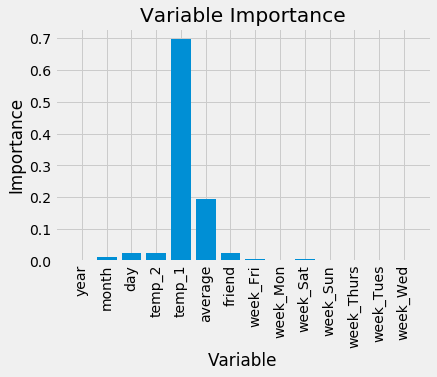

In [32]:
plt.style.use('fivethirtyeight')
x_values = list(range(len(importances)))

plt.bar(x_values, importances, orientation='vertical')
plt.xticks(x_values, feature_list, rotation='vertical')

plt.ylabel('Importance')
plt.xlabel('Variable')
plt.title('Variable Importance')